### Figure 2: Cell Turnover, Anisomycin Effects, and Placefield Stability Remapping

Note that you must run through `run_placefields.py` for each mouse to check day-to-day alignment of behavioral data before running most of the place field related functions below.

In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten

### Set up plots

In [2]:
Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb = None, None, None, None, None

[6.375 4.875]


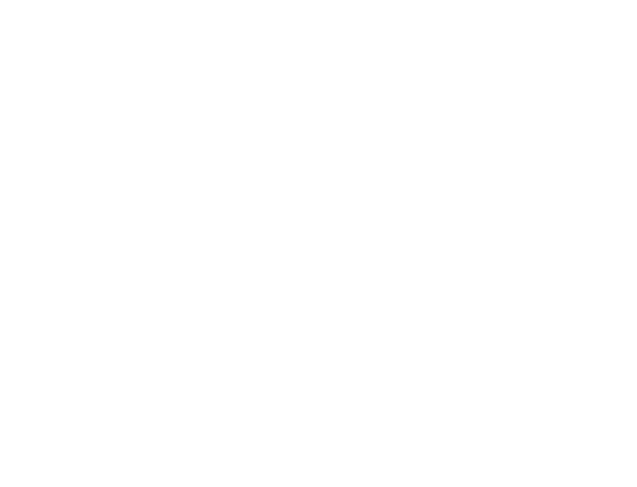

In [3]:
# Set up main figure plotting
%matplotlib ipympl
Fig2 = Fig(num=2, grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())

[6.375 4.875]


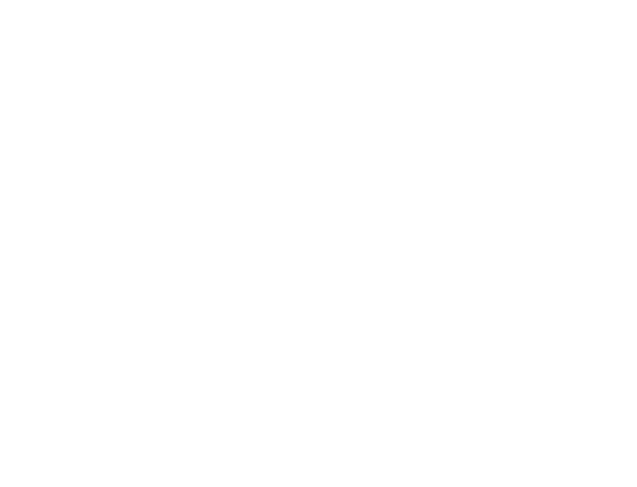

In [4]:
# Set up stats figure
Fig2stats = Fig(num="Figure 2 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())
Fig2comb = FigMirror(Fig2, Fig2stats)

[6.375 4.875]


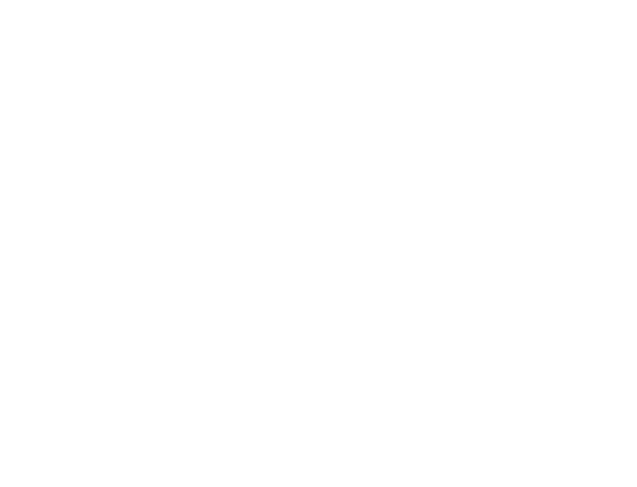

In [5]:
# Set up supplemental fig + stats
FigS4 = Fig(num="Figure S4", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4.fig.get_size_inches())

[6.375 4.875]


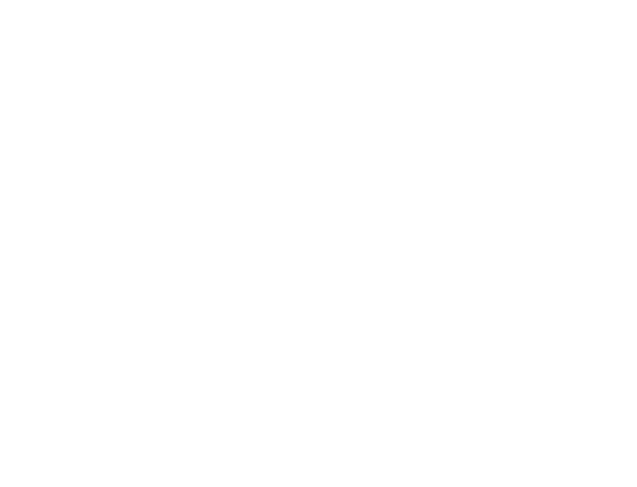

In [6]:
FigS4stats = Fig(num="Figure S4 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4stats.fig.get_size_inches())
FigS4comb = FigMirror(FigS4, FigS4stats)

### Fig 2A-B: Cell turnover across days

In [7]:
# Test code for reshaping - want 1st index from 3rd dim folded into 2nd, e.g. combine shock v shock and open v open
# Not currently used, but could be useful if we need to add in "open" v "open" overlaps at some later point, no
# currently included, only "shock" v "shock"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a[:, :, 1] = a[:, :, 1]*10
print(a)
# So 1, 4, 7, and 20, 50, 80 are same arena, 3, 6, 9 are different
b = np.append(a, np.nan*np.ones_like(a[:, :, 2, None]), axis=2)
c = b.reshape((int(b.shape[0]*2), b.shape[1], int(b.shape[2]/2)), order='F')
print('3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80')
print(c[:, :, 0])
print('3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan')
print(c[:, :, 1])
# Ok, so this works - things are grouped appropriately

[[[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]

 [[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]]
3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80
[[ 1.  7. 50.]
 [ 1.  7. 50.]
 [ 4. 20. 80.]
 [ 4. 20. 80.]]
3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan
[[ 3.  9. nan]
 [ 3.  9. nan]
 [ 6. nan nan]
 [ 6. nan nan]]


0.2985781990521327


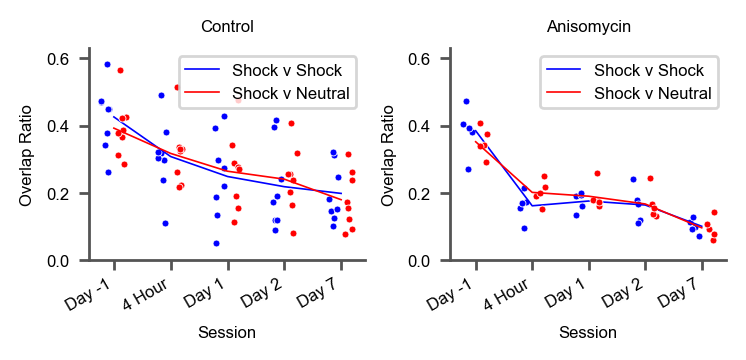

In [8]:
plot_ind = False
ylims = (0, 0.63)

axolap_ctrl = Fig2.subplot(441)
axolap_ani = Fig2.subplot(442)

oratioboth_comb = []
base_day = -2
for ax, mice, group_title in zip([axolap_ctrl, axolap_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
    days = [-1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                    if (mouse == "Marble14") and (arena_pair[1] == "Shock") and (day == 4):
                        _, _, a, _, _ = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                        print(a)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days, size=4, linewidth=0.2, edgecolor='w')
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.09, 0.09], colors = ['b', 'r'], offset=(-0.14, 0.14),
                            arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.5,
                            meanlinewidth=0.6, markeredgecolor='w', markeredgewidth=0.3)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')
    ax.set_ylim(ylims)
    fix_xlabels(ax, rotate=True)

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it
Fig2.fig

#### Per KD analysis suggestion make the above plot but use 4 hour session as baseline. Not informative

In [ ]:
# plot_ind = False

# fig4, ax4 = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
# axolap4_ctrl = ax4[0]
# axolap4_ani = ax4[1]

# oratioboth_comb = []
# base_day = 4
# # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
# days = [-2, -1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
# for ax, mice, group_title in zip([axolap4_ctrl, axolap4_ani], [err.control_mice_good, err.ani_mice_good], 
#                                  ["Control", "Anisomycin"]):
#     days_use = [day for day in days if day != base_day]
#     arenas = [["Shock", "Shock"], ["Shock", "Open"]]
#     oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

#     # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
#     pathname = err.pathname  # Get plotting folder
#     for idm, mouse in enumerate(mice):
#         for idd, day in enumerate(days_use):
#             for ida, arena_pair in enumerate(arenas):
#                 try:
#                     _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
#                         pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
#                 except TypeError:
#                     print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

#         if plot_ind:
#             fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days)
#             fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
#             plt.close(fig)
    
#     _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.05, 0.05], colors = ['b', 'r'], 
#                               arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.0)
#     ax.set_title(group_title)
#     ax.set_ylabel('Overlap Ratio')

#     oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.

### 2C Now quantify accelerated change and then slower change (measured by cell overlap) due to ANI administration

In [ ]:
# Dump data into dataframe for easy plotting in seaborn afterward...
day_pairs = ['-1_4', '4_1', '1_2', '2_7']
grp_list, dolap_list, day_list = [], [], []
grp_mean_list, dolap_mean_list, day_mean_list = [], [], []
for idg, grp in enumerate(['Ctrl', 'ANI']):
    oratio_use = oratioboth_comb[idg]
    for idd, day_pair in enumerate(day_pairs):
        dolap = oratio_use[:, idd, :].reshape(-1) - oratio_use[:, idd + 1, :].reshape(-1)
        dolap_list.extend(dolap)
        grp_list.extend(len(dolap)*[grp])
        day_list.extend(len(dolap)*[day_pair])

        dolap_mean = (oratio_use[:, idd, :] - oratio_use[:, idd + 1, :]).mean(axis=1)
        dolap_mean_list.extend(dolap_mean)
        grp_mean_list.extend(len(dolap_mean)*[grp])
        day_mean_list.extend(len(dolap_mean)*[day_pair])

dolap_df = pd.DataFrame({'day_pair': day_list, 'dolap': dolap_list, 'Group': grp_list})
dolap_mean_df = pd.DataFrame({'day_pair': day_mean_list, 'dolap': dolap_mean_list, 'Group': grp_mean_list})

In [ ]:
### Plot means
axolap_bw, axolap_bw_stats = Fig2comb.subplot(443)
# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
hdolap = sns.stripplot(data=dolap_mean_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
                       ax=axolap_bw, size=2.5, linewidth=0.3, edgecolor='w', jitter=0.15)
# Fix legend markers
for h1 in hdolap.legend().legendHandles:
    h1._sizes = [3]
axolap_bw.set_ylabel(r'$\Delta_{overlap}$')
axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
axolap_bw.set_xlabel('Day Pair')

In [ ]:
ytext = 0.7
axolap_bw_stats.text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_mean_df['day_pair']):
    ctrl = dolap_mean_df[(dolap_mean_df['Group'] == 'Ctrl') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_mean_df[(dolap_mean_df['Group'] == 'ANI') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit', alternative="two-sided")
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    axolap_bw_stats.text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

In [ ]:
dolap_df.day_pair.values

In [ ]:
sns.__version__

In [ ]:
# Plot all data points individually for reference
_, ax = plt.subplots(1, 2, figsize=(6, 3))

# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
# hdolap = sns.stripplot(data=dolap_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
#                        ax=ax[0], size=3.5, linewidth=0.2, edgecolor='w', jitter=0.15)
hdolap = sns.stripplot(data=dolap_df, x='day_pair', y='dolap',
                       ax=ax[0])
# Fix legend markers
for h1 in hdolap.legend().legendHandles:
    h1._sizes = [3]
ax[0].set_ylabel(r'$\Delta_{overlap}$')
ax[0].set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
ax[0].set_xlabel('Day Pair')

In [ ]:
ytext = 0.7
ax[1].text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_df['day_pair']):
    ctrl = dolap_df[(dolap_df['Group'] == 'Ctrl') & (dolap_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_df[(dolap_df['Group'] == 'ANI') & (dolap_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit')
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ax[1].text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

### Plot Number of Neurons active for each session

In [ ]:
# Aggregate #neurons

days = [-2, -1, 4, 1, 2, 7]

arenas = ['Shock', 'Open']
nneurons_comb = []
for mice in [err.control_mice_good, err.ani_mice_good]:

    # # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
    nanimals = nneurons.shape[0]
    nneurons_comb.append(nneurons.reshape(int(2*nanimals), 1, len(days)))  # Combine both areas for each mouse

# Now plot - Total #s (un-normalized) plotted in supplemental
ax_nn_comb, ax_nn_comb_stats = Fig2comb.subplot(444)
# _, ax_nn_comb = plt.subplots()
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
for nn, color, jitter in zip(nneurons_comb, pal_use[0:2], (-0.075, 0.075)):
    ct.plot_num_neurons(nn, arena1='Combined', arena2=None, normalize='-2', colors=[color], jitter=jitter,
                        markersize=2.0, ax=ax_nn_comb)

In [ ]:
nneurons_norm = [ct.norm_num_neurons(nn, 0) for nn in nneurons_comb]
ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

Plot #6: Plot of off cells by quartile - plotted separately by Dan Orlin in MATLAB

In [ ]:
# Put in placeholder
ax_onoff = Fig2comb.subplot(445)
ax_onoff[0].text(0.1, 0.5, 'Placeholder for DO on/off by quartile plot')

Plot #6a (Supplemental 1): Example max projections showing washout in ANI recordings - include with more raw data from other animals.

Plot #7: Example place-fields across sessions  

Marble07, Shock Day -2 to Day -1 gives neuron #27 has a good example neuron. Grab a few others maybe? Example of remapping neuron?

In [ ]:
gs_pf_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[2,0], grid=(2,2))
axp = []
for i in range(2):
    for j in range(2):
        axp.append(Fig2.fig.add_subplot(gs_pf_subfig[i, j]))
axp = np.array(axp).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', -1)
nneuron = 27
PFS1.pfplot(nneuron, ax=axp, linewidth=0.5, markersize=1.0)

In [ ]:
Fig2.fig

In [ ]:
gs_pf_subfig2 = Fig2.subplot2grid(subplot_spec=Fig2.gs[1,0], grid=(2,2))
axp2 = []
for i in range(2):
    for j in range(2):
        axp2.append(Fig2.fig.add_subplot(gs_pf_subfig2[i, j]))
axp2 = np.array(axp2).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', 1)
nneuron = 64
PFS1.pfplot(nneuron, ax=axp2, linewidth=0.5, markersize=1.0)

Plot #7a (Supplemental 2): Example place fields from Learner, Non-Learner, and ANI. Plot by quartile - two from each maybe?

Plots #8: Placefield stability and reorganization across days - ANI reduces shock-induced PF remapping and also stifles extinction-related remapping.  

In [ ]:
# Scatterplot for each group independently
group_desig = 2  # 1 = include days 1,2, AND 7 in after shock group, 2 = include days 1 and 2 only

figc, axc = plt.subplots(1,2)
figc.set_size_inches((8.5, 3.5))
for arena, a in zip(['Shock', 'Open'], axc):
    _, cont_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.nonlearners, arena, arena, days, 
                                                            batch_map_use=True, print_to_screen=False)
    _, ani_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.ani_mice_good, arena, arena, days, 
                                                           batch_map_use=True, print_to_screen=False)

    # Combined scatterplot
    pfs.plot_pfcorr_bygroup(cont_corr_sm_mean_all, arena, arena, '', ax_use=a,
                            color='k', offset=-0.1, save_fig=False, group_desig=group_desig)
    pfs.plot_pfcorr_bygroup(ani_corr_sm_mean_all, arena, arena, 'Combined (green=Ani)',
                        color='g', offset=0.1, ax_use=a, group_desig=group_desig, best_rot=False)

In [ ]:
def assemble_mean_corrs_all(corr_type: str in ['PF', 'PV1dboth', 'PV1all'], best_rot: bool, group_desig: int in [1, 2],
                       plot=False, nshuf=0):
    """Assemble pre-run MEAN place-field or MEAN population-vector correlations.
    :param corr_type: 2d PFs, 1d pv including only cells active in both sessions or all sessions
    :param best_rot: only applies to 2d PFs. True = rotate map to best rotation
    :param group_desig: 1 = include day 7 in "After" comparisons, 2 = only include days 1-2 (before more extinction happens)
    """
    # Need to run this to set up plots - I'm sure there is a better way...one option is to write code to assemble
    # these values for each day-pair independently...
    amice = err.ani_mice_good
    lmice = err.learners
    nlmice = err.nonlearners
    days = [-2, -1, 4, 1, 2, 7]

    learn_bestcorr_mean_all = []
    nlearn_bestcorr_mean_all = []
    ani_bestcorr_mean_all = []
    
    l_shuf_all, nl_shuf_all, ani_shuf_all = [], [], []

    if plot:
        figc, axc = plt.subplots(1,2)
        figc.set_size_inches((8.5, 3.5))
        
    for ida, arena in enumerate(['Open', 'Shock']):
        arena1 = arena
        arena2 = arena
        if corr_type == 'PF':
            _, templ, _, templ_shuf = pfs.get_group_pf_corrs(lmice, arena1, arena2, days, best_rot=best_rot, 
                                                             print_to_screen=False, nshuf=nshuf)
            _, tempnl, _, tempnl_shuf = pfs.get_group_pf_corrs(nlmice, arena1, arena2, days, best_rot=best_rot, 
                                                               print_to_screen=False, nshuf=nshuf)
            _, tempa, _, tempa_shuf = pfs.get_group_pf_corrs(amice, arena1, arena2, days, best_rot=best_rot, 
                                                             print_to_screen=False, nshuf=nshuf)
            prefix = 'PFcorrs'
        elif corr_type == 'PV1dboth':
            _, templ, _, templ_shuf = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False,
                                                               nshuf=nshuf)
            _, tempnl, _, tempnl_shuf = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False,
                                                                 nshuf=nshuf)
            _, tempa, _, tempa_shuf = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            prefix = 'PV1dcorrs_both'
        elif corr_type == 'PV1dall':
            templ, _, templ_shuf, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            tempnl, _, tempnl_shuf, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False, 
                                                                 nshuf=nshuf)
            tempa, _, tempa_shuf, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
                                                               nshuf=nshuf)
            prefix = 'PV1dcorrs_all'

        learn_bestcorr_mean_all.append(templ)
        nlearn_bestcorr_mean_all.append(tempnl)
        ani_bestcorr_mean_all.append(tempa)
        
        l_shuf_all.append(templ_shuf)
        nl_shuf_all.append(tempnl_shuf)
        ani_shuf_all.append(tempa_shuf)

        #  Combined scatterplots
        if plot:
            pfs.plot_pfcorr_bygroup(learn_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix, ax_use=axc[ida],
                                                color='k', offset=0, save_fig=False, group_desig=group_desig)
            pfs.plot_pfcorr_bygroup(ani_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
                                    color='g', offset=0.1, ax_use=axc[ida], group_desig=group_desig, save_fig=False)
            pfs.plot_pfcorr_bygroup(nlearn_bestcorr_mean_all[ida], arena1, arena2,
                                    prefix + ' ' + arena1 + 'v' + arena2 + ' Combined (k=learn, b=n-learn, g=Ani) best_rot=' + 
                                    str(best_rot), prefix=prefix, color='b', offset=0.1, ax_use=axc[ida], 
                                    group_desig=group_desig, save_fig=True, best_rot=best_rot)
        
    if nshuf == 0:
        return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all
    else:
        return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, l_shuf_all, nl_shuf_all, ani_shuf_all

# Now run it to get a plot of raw data and test things out

a, b, c, d, e, f = assemble_mean_corrs_all(corr_type='PV1dboth', best_rot=True, group_desig=2, plot=True, nshuf=1000)

In [ ]:
def mean_corrs_to_df(learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, group_desig):
    """Dump output of above function into dataframe"""
    # Assemble mean correlations
    lgroups, group_labels = pfs.get_time_epochs(len(err.learners), group_desig)
    agroups, _ = pfs.get_time_epochs(len(err.ani_mice_good), group_desig)
    nlgroups, _ = pfs.get_time_epochs(len(err.nonlearners), group_desig)
    corrs_all, grp_all, arena_all, comp_type, subject_id = [], [], [], [], []
    for idg, (group, grp_label) in enumerate(zip(np.unique(lgroups[~np.isnan(lgroups)]).tolist(), group_labels)):
        open_corrs1 = learn_bestcorr_mean_all[0][lgroups == group]
        shock_corrs1 = learn_bestcorr_mean_all[1][lgroups == group]
        open_corrs2 = ani_bestcorr_mean_all[0][agroups == group]
        shock_corrs2 = ani_bestcorr_mean_all[1][agroups == group]
        open_corrs3 = nlearn_bestcorr_mean_all[0][nlgroups == group]
        shock_corrs3 = nlearn_bestcorr_mean_all[1][nlgroups == group]

        # Assemble data-frame!!!
        sid_prefix = 0
        for open_corr, shock_corr, grp in zip([open_corrs1, open_corrs2, open_corrs3], 
                                              [shock_corrs1, shock_corrs2, shock_corrs3], 
                                              ['Learners', 'ANI', 'Non-Learners']):
            corrs_all.extend(open_corr)
            grp_all.extend([grp]*len(open_corr))
            arena_all.extend(['Neutral']*len(open_corr))

            corrs_all.extend(shock_corr)
            grp_all.extend([grp]*len(shock_corr))
            arena_all.extend(['Shock']*len(shock_corr))

            comp_type.extend([grp_label]*(len(shock_corr) + len(open_corr)))

            if len(open_corr) != len(shock_corr):
                print('Mismatch in group ' + grp + ' ' + grp_label)
            elif len(open_corr) == len(shock_corr):
                subject_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for open field corrs
                subject_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for shock arena corrs
                sid_prefix += 100

    corr_df = pd.DataFrame({'corr': corrs_all, 'arena': arena_all, 'group': grp_all, 'comp_type': comp_type, 
                           'subject': subject_id})
    
    return corr_df

Functions for plotting group-wise comparison scatter/box plots here

In [ ]:
def pfplot_compare2(corr_df, comp_plot, ax, alpha=0.5, within_first=False, ax_lims=[0, 0.6], dotsize=3,
                   anova_type: str in ['normal', 'mixed'] = 'mixed', legend_keep=False, **kwargs):
    """Plotting function to overlay pf correlation stripplot with boxplot.
    **kwargs send to plt.text()"""
    boxprops = dict(alpha=alpha)
    
    # Plot data and label
    sns.stripplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
    sns.boxplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
    if not legend_keep:
        ax[0].get_legend().remove()
    ax[0].set_ylim(ax_lims)
    ax[0].set_xlabel('Arena')
    ax[0].set_ylabel('Mean PF Corr.')
    ax[0].set_title(comp_plot)
    
    # Now run stats: 2-way or mixed anova and post-hoc test
    aov = pg.anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', between=['arena', 'group']).round(5)
    maov = pg.mixed_anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', 
                          within='arena', between='group', subject='subject').round(3)
    if anova_type == 'normal':
        ax[1].text(0.05, 0.8, aov.to_string(index=False), **kwargs)
    elif anova_type == 'mixed':
        ax[1].text(0.05, 0.8, maov.to_string(index=False), **kwargs)  
            
    pw = pg.pairwise_tests(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', within_first=within_first,
                          within='arena', between='group', subject='subject', padjust='bonf').round(3)
    pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
    ax[1].text(0.05, 0.05, pwtrim.to_string(index=False), **kwargs)

In [ ]:
def get_CI_mean(group, arena, comparison, group_desig):
    """Gets mean CIs for 2d PF correlations only"""
    # Get shuffled mean correlations
    shuf_CI_all = []
    for mouse in group:
        shuf_CI_temp = pfs.get_all_CIshuf(mouse, arena, arena, print_to_screen=False)
        shuf_CI_all.append(shuf_CI_temp)
    shuf_CI_all = np.stack(shuf_CI_all, axis=0)

    # Grab appropriate session-pair(s)
    nmice = len(group)
    group_mat, group_labels = pfs.get_time_epochs(nmice, group_desig)
    comp_id = np.where([label == comparison for label in group_labels])[0] + 1
    keep_bool = group_mat[0] == comp_id

    comp_shuf_CI = shuf_CI_all[:, :, keep_bool].squeeze()
    
    return comp_shuf_CI

In [ ]:
def add_shuf_CI(ax, comparison, group_desig):
    """Add confidence intervals (95%) from shuffled data to plots for mean correlation value - for PF2d only"""
    groups = [err.learners, err.ani_mice_good, err.nonlearners]
    x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True
    
    for ida, arena in enumerate(['Neutral', 'Shock']):
        # Get CIs
        CI_comb = []
        for group in groups:
            comp_shuf_CI = get_CI_mean(group, 'Open' if arena == 'Neutral' else arena, 
                                       comparison, group_desig)  # Get shuffled CI for all mice in group
            if comp_shuf_CI.ndim == 3:  # Reshape if more than one set of day-pairs in comparison
                comp_shuf_CI = comp_shuf_CI.swapaxes(0,1).reshape(3,-1).T
            CI_comb.append(np.nanmean(comp_shuf_CI, axis=0))  # Average it, add it into grou
        CI_plot = np.stack(CI_comb)  # make into array
        
        # Add to plot
        hl = ax.plot(x_offset + ida, CI_plot, linestyle='--', color=[0, 0, 0, 0.5])
        hl[1].set_linestyle('-')

In [ ]:
def calc_PV1d_CI_from_mean_corrs(mean_shuf_corrs):
    """Calculates mean CI across all mice in a group. 
    Input = nmice x ndays x ndays x nshuffles arrray of mean shuffled values"""
    mean_CI = np.array([np.insert(np.quantile(_, (0.025, 0.975), axis=2), 1, 
                                  np.mean(_, axis=2)[None, :, :], axis=0) for _ in mean_shuf_corrs]).mean(axis=0)
    return mean_CI

In [ ]:
def add_PV1shuf_CI(ax, learn_shuf_all, nl_shuf_all, ani_shuf_all, comparison, group_desig):
    """Add shuffled CIs to PV1d plots"""
    x_offset = np.array([-0.25, 0, 0.25])

    # ID appropriate session-pair(s)
    group_mat, group_labels = pfs.get_time_epochs(2, group_desig)
    comp_id = np.where([label == comparison for label in group_labels])[0] + 1
    keep_bool = group_mat[0] == comp_id

    for ida, arena in enumerate(['Neutral', 'Shock']):
        CI_comb = []
        for shuf_corrs in [l_shuf_all[ida], nl_shuf_all[ida], ani_shuf_all[ida]]:  # Grab corrs for that arena only
            mean_CI_shuf = calc_PV1d_CI_from_mean_corrs(shuf_corrs)
            CI_comb.append(mean_CI_shuf[:, keep_bool])
        CI_plot = np.array(CI_comb).squeeze()
        if CI_plot.ndim == 3:  # Take mean again if more than 1 session-pair
            CI_plot = CI_plot.mean(axis=2)
        hl = ax.plot(x_offset + ida, CI_plot, linestyle='--', color=[0, 0, 0, 0.5])
        hl[1].set_linestyle('-')

# Test code - uncomment to check function working properly
# _, ax = plt.subplots()
# add_PV1shuf_CI(ax, l_shuf_all, nl_shuf_all, ani_shuf_all, 'Before v After(Days1-2)', 2)

### Finally plot PF corrs by mouse into Figure 2 and S4 here.

In [ ]:
# Assemble dataframe
learn_corr_all, nl_corr_all, ani_corr_all = assemble_mean_corrs_all(corr_type='PF', best_rot=True, 
                                                                    group_desig=group_desig, plot=False)
corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

# Set up plots for Fig2 and FigS4
ax_bef_comb = Fig2comb.subplot([Fig2.gs[2, 1], Fig2stats.gs[2, 1]])
ax_aft_comb = Fig2comb.subplot([Fig2.gs[2, 2], Fig2stats.gs[2, 2]])
ax_ba_comb = Fig2comb.subplot([Fig2.gs[2, 3], Fig2stats.gs[2, 3]])
ax_bstm_comb = FigS4comb.subplot(445)
ax_stma_comb = FigS4comb.subplot(446)

# Set up plotting params
ax_lims = [-0.1, 0.6]
anova_type = 'mixed'
within_first = True

# Now make the plots
for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
                        corr_df['comp_type'].unique()):
    legend_keep = True if comp_type in ['Before', 'Before v STM'] else False
    pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
                   legend_keep=legend_keep, fontdict={"size": 3})
    add_shuf_CI(a[0], comp_type, group_desig)

Plot #11: compare before to after to examine stability change due to shock

Plot #9-10: same thing but combining all mice - plot ecdfs at various time points to look at remapping.

In [ ]:
# Define axes to plot into

# Main fig
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 1], grid=(1,2))
ax_all_bef_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(446)]
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 2], grid=(1,2))
ax_all_aft_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(447)]
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 3], grid=(1,2))
ax_all_ba_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(448)]

# Supplemental Fig
gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 0], grid=(1,2))
ax_all_bstm_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(441)]
gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 1], grid=(1,2))
ax_all_stma_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(442)]

ax_allpf_comb = [ax_all_bef_comb, ax_all_aft_comb, ax_all_ba_comb, ax_all_bstm_comb, ax_all_stma_comb]

In [ ]:
Fig2inset = Fig(num="Figure 2 Inset", grid=(2, 3), size=(6.5, 2*2 ), fontsize=6)
Fig2inset_stats = Fig(num="Figure 2 Inset stats", grid=(2, 3), size=(8.5, 2.5*3 ), fontsize=6)
Fig2insetcomb = FigMirror(Fig2inset, Fig2inset_stats)

# Main fig
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 0], grid=(1,2))
ax_all_bef_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(231)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 1], grid=(1,2))
ax_all_aft_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(232)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 2], grid=(1,2))
ax_all_ba_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(233)]

gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 0], grid=(1,2))
ax_all_bstm_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(234)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 1], grid=(1,2))
ax_all_stma_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(235)]

ax_allpf_comb_i = [ax_all_bef_comb_i, ax_all_aft_comb_i, ax_all_ba_comb_i, ax_all_bstm_comb_i, ax_all_stma_comb_i]

In [ ]:
# Function here to add in stats to ecdf group
def add_ks_stats_to_ecdf(group_corrs, ax_use, ytext_start=0.8, bonf_corr=3, **kwargs):
    id1, id2 = [0, 0, 1], [1, 2, 2]
    group_names = ['Learners', 'Non-Learners', 'ANI']
    y = ytext_start
    for i1, i2 in zip(id1, id2):
        kstat, pval = sstats.ks_2samp(group_corrs[i1], group_corrs[i2])
        ax_use.text(0.1, y, f'{group_names[i1]} v {group_names[i2]}: pval={pval*bonf_corr:0.3g}, kstat={kstat:0.3g}',
                   **kwargs)
        y -= 0.1

In [ ]:
# Assemble and plot ecdfs
groups = [err.learners, err.nonlearners, err.ani_mice_good]
group_names = ['Learners', 'Non-Learners', 'ANI']
days = np.array([-2, -1, 4, 1, 2, 7])
best_rot = True
bonferroni_correction = 3 # multiply by this for bonferroni correction for multiple comparisons

epochs, group_labels = pfs.get_time_epochs(2, group_desig=group_desig)

rot_append = ': Best Rotation' if best_rot else ''
all_corrs = []
for ax, axin, comp in zip(ax_allpf_comb, ax_allpf_comb_i, group_labels):
    ax[0][0].set_title(comp + rot_append)
    comp_id = np.where([comp == group for group in group_labels])[0][0] + 1
    arena_corrs = []
    for ida, (a, ain, arena) in enumerate(zip(ax[0], axin[0], ['Open', 'Shock'])):

        # Aggregate corrs for arena
        days1, days2 = [days[id] for id in np.where(epochs[0] == comp_id)]
        group_corrs = []
        for group in groups:
            mouse_corrs = []
            for mouse in group:
                for day1, day2 in zip(days1, days2):
                    # Rotate pf maps to best rotation if specified
                    if best_rot:
                        _, rot_use, _ = pfs.get_best_rot(mouse, arena, int(day1), arena, int(day2), 
                                                         batch_map_use=True, print_to_screen=False)
                        rot = rot_use[1]
                    else:
                        rot = 0
                    _, corrs_sm = pfs.pf_corr_bw_sesh(mouse, arena, int(day1), arena, int(day2), batch_map_use=True,
                                                     rot_deg=rot)
                mouse_corrs.extend(corrs_sm)
            group_corrs.append(mouse_corrs)

        # Plot for arena
        line_types = ['-', '--', ':']
        for idc, corrs in enumerate(group_corrs):
            sns.ecdfplot(data=corrs, ax=a, color=plt.get_cmap("Set2").colors[idc], linewidth=0.5, 
                         linestyle=line_types[idc])

        if arena == 'Open':
            a.legend(a.lines, ['Learners', 'Non-Learners', 'ANI'])
            arena_str = 'Neutral'
        elif arena == 'Shock':
            arena_str = 'Shock'
        a.set_title(arena_str)
        a.set_xlabel('PF corrs')
        
        # Stats
        ax[1].text(0.1, 1.0, comp)
        ystatloc = 0.9 if arena == 'Open' else 0.4
#         print(str(ystatloc))
        ax[1].text(0.1, ystatloc, f'{arena_str}: pvals w/bonf corr={bonferroni_correction}')
        add_ks_stats_to_ecdf(group_corrs, ax[1], 0.8 - (0.4 * ida), bonf_corr=bonferroni_correction,
                             fontdict={"size": 3})
        arena_corrs.append(group_corrs)
        
        # Plot out inset bar plots
        dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
                              'Group' : list(flatten([[group_name]*len(group_corr) for 
                                                      group_corr, group_name in zip(group_corrs, group_names)]))})
        sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ain, errwidth=1.0, palette='Set2')
        ain.set_title(f'{arena_str}: {comp}')
        astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc + 0.1, f'{arena_str}: {comp}')
        axin[1].text(0.1, ystatloc, str(astats))
        tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc-0.3, str(tuk_stats))
        
        
    all_corrs.append(arena_corrs)


In [ ]:
# Sanity check plots to make sure colors are being applied properly - uncomment if needed
# _, ax2 = plt.subplots(1, 2)
# for corrs in group_corrs:
#     sns.ecdfplot(data=corrs, ax=ax2[1], palette='Set2', linewidth=0.5)

# ax2[1].legend(ax2[1].lines, ['Learners', 'Non-Learners', 'ANI'])

# sns.set_palette("Set2")
# sns.ecdfplot(data=group_corrs[0], ax=ax2[0], color=plt.get_cmap("Set2").colors[0], linewidth=0.5)

### Plot PV1d corrs (both) here

In [ ]:
# Test code for plotting out combined data means
dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
                      'Group' : list(flatten([[group_name]*len(group_corr) for 
                                              group_corr, group_name in zip(group_corrs, group_names)]))})
fig, ax = plt.subplots(figsize=(2.0, 2.5))
sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ax, errwidth=1.0, palette='Set2')
astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
print(astats)
tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
print(tuk_stats)

In [ ]:
FigS4b = Fig(num="Figure S4b", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4b.fig.get_size_inches())
FigS4bstats = Fig(num="Figure S4bstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4bstats.fig.get_size_inches())
FigS4bcomb = FigMirror(FigS4b, FigS4bstats)

In [ ]:
FigS4c = Fig(num="Figure S4c", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4c.fig.get_size_inches())
FigS4cstats = Fig(num="Figure S4cstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4cstats.fig.get_size_inches())
FigS4ccomb = FigMirror(FigS4c, FigS4cstats)

In [ ]:
for figcomb, corr_type, ax_lims in zip((FigS4bcomb, FigS4ccomb), ['PV1dboth', 'PV1dall'], ([-0.4, 0.8], [-0.8, 0.4])):
    
    # Assemble dataframe
    corrs_tup = assemble_mean_corrs_all(corr_type=corr_type, best_rot=True, group_desig=group_desig, plot=False, nshuf=1000)
    learn_corr_all, nl_corr_all, ani_corr_all, l_shuf_all, nl_shuf_all, ani_shuf_all = corrs_tup
    corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

    # Now plot into S4b and S4c
    ax_bef_comb = figcomb.subplot(441)
    ax_aft_comb = figcomb.subplot(442)
    ax_ba_comb = figcomb.subplot(443)
    ax_bstm_comb = figcomb.subplot(444)
    ax_stma_comb = figcomb.subplot(445)

    anova_type = 'mixed'
    within_first = True

    for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
                            corr_df['comp_type'].unique()):
        legend_keep = True if comp_type == 'Before' else False
        pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
                       legend_keep=legend_keep)
        add_PV1shuf_CI(a[0], l_shuf_all, nl_shuf_all, ani_shuf_all, comp_type, group_desig)
        
    figcomb.Fig1.fig.suptitle(corr_type)

In [ ]:
FigS4b.fig

In [ ]:
FigS4c.fig

### NRK todo: look at overall event rate across days, normalized to day -1 for each mouse. Compare between groups.

2) Plot overlap between arenas for ANI vs Ctrls across all days - 4 hr session could be super interesting for ANI.

#2) Plot delta ER for ANI neurons vs. Ctrl neurons from -1 to -4 to 1 in shock arena

In [ ]:
peak_mean_c, peak_mean_a = [], []
def assemble_mean_peak(mice, day1, day2, arena, group_type=None):
    mean_peak_all, days_all, arena_all, animal_id = [], [], [], []
    for idm, mouse in enumerate(mice):
        a, b = discr.get_matched_peak_heights(mouse, arena, day1, arena, day2)
        mean_peak_all.extend([a.mean(), b.mean()])
        days_all.extend([day1, day2])
        arena_all.extend([arena, arena])
        animal_id.extend([idm, idm])
    if group_type is None:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Mean Peak Height': mean_peak_all})
    else:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Group': [group_type]*len(days_all), 'Mean Peak Height': mean_peak_all})


In [ ]:
FigS4comb.Fig1.fig

In [ ]:
# Plot mean of transient peaks for each session before/after ANI admin.
# ax_anipeak_14, ax_anipeak_14stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,0], grid=(1,2), return_axes=True)
# ax_anipeak_1n1, ax_anipeak_1n1stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,1], grid=(1,2), return_axes=True)

# For some reason things are plotting weird into FigS4 directly, so here is a workaround
fig_anipeak, ax_anipeak = plt.subplots(2, 2, figsize=(8.5/4, 6.5/2))
fig_anipeak_stats, ax_anipeak_stats = plt.subplots(2, 2, figsize=(4.25, 6.5/2))
ax_anipeak_14, ax_anipeak_1n1 = ax_anipeak
ax_anipeak_14stats, ax_anipeak_1n1stats = ax_anipeak_stats
day_pairs = [[-1, 4], [-1, 1]]
for ax, axs, day_pair in zip([ax_anipeak_14, ax_anipeak_1n1], [ax_anipeak_14stats, ax_anipeak_1n1stats], day_pairs):
    df_ctrl = assemble_mean_peak(err.control_mice_good, day_pair[0], day_pair[1], 'Open', 'Control')
    df_ani = assemble_mean_peak(err.ani_mice_good, day_pair[0], day_pair[1], 'Open', 'ANI')
    ax[0].get_shared_y_axes().join(ax[0], ax[1])
    ax[1].set_yticklabels([])
    for ida, (a, df) in enumerate(zip(ax, [df_ctrl, df_ani])):
        g = sns.pointplot(data=df, x='Day', y='Mean Peak Height', hue='Animal', ax=a, scale=0.5,
                          palette=[plt.get_cmap('Set2').colors[ida*2]]*len(df['Animal'].unique()), legend=False)
        g.legend_.remove()
        a.set_title(df['Group'][0])
        sns.despine(ax=a)
        
        stats = pg.ttest(df[df['Day'] == day_pair[0]]['Mean Peak Height'], 
                      df[df['Day'] == day_pair[1]]['Mean Peak Height'])
        axs[0].set_title(f'Mean Peak height day {day_pair[0]} to day {day_pair[1]}')
        axs[0].text(0.1, 0.9 - ida * 0.5, f"{df['Group'][0]} t-test")
        axs[0].text(0.1, 0.6 - ida * 0.5, str(stats), fontdict={"size": 3})
        axs[1].axis('off')
        


In [ ]:
FigS4.fig

## Save all figures

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
for comb_fig_save, name in zip([Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb], 
                               ['Figure2', 'FigureS4', 'FigureS4b_PV1dboth', 'FigureS4c_PV1dall', 'Figure2inset']):
    if comb_fig_save is not None:
        comb_fig_save.Fig1.savefig(plot_path / (name + '.pdf'), scriptname = 'Figure2_and_S4.ipynb')
        comb_fig_save.Fig2.savefig(plot_path / (name + '_stats.pdf'), scriptname = 'Figure2_and_S4.ipynb')

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig2insetcomb.Fig1.savefig(plot_path / 'Figure2inset.pdf', scriptname = 'Figure2_and_S4.ipynb')
Fig2insetcomb.Fig2.savefig(plot_path / 'Figure2inset_stats.pdf', scriptname = 'Figure2_and_S4.ipynb')
fig_anipeak.savefig(plot_path / 'FigureS4_transient_peaks.pdf')
fig_anipeak_stats.savefig(plot_path / 'FigureS4_transient_peaks_stats.pdf')